Saving df_merge.csv to df_merge (1).csv
Dataset preview:
   Unnamed: 0                                              title  \
0           0   Donald Trump Sends Out Embarrassing New Year’...   
1           1   Drunk Bragging Trump Staffer Started Russian ...   
2           2   Sheriff David Clarke Becomes An Internet Joke...   
3           3   Trump Is So Obsessed He Even Has Obama’s Name...   
4           4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  class  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-3-85874938d19a>:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/300 [00:00<?, ?i

Epoch 1 - Training Loss: 0.7023, Validation Accuracy: 0.5000
Precision: 0.3333, Recall: 0.0101, F1 Score: 0.0196


<ipython-input-3-85874938d19a>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
 67%|██████▋   | 200/300 [22:59<11:00,  6.60s/it]

Epoch 2 - Training Loss: 0.6942, Validation Accuracy: 0.4850
Precision: 0.1667, Recall: 0.0101, F1 Score: 0.0190


<ipython-input-3-85874938d19a>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 300/300 [34:50<00:00,  6.27s/it]

Epoch 3 - Training Loss: 0.6870, Validation Accuracy: 0.4850
Precision: 0.1667, Recall: 0.0101, F1 Score: 0.0190


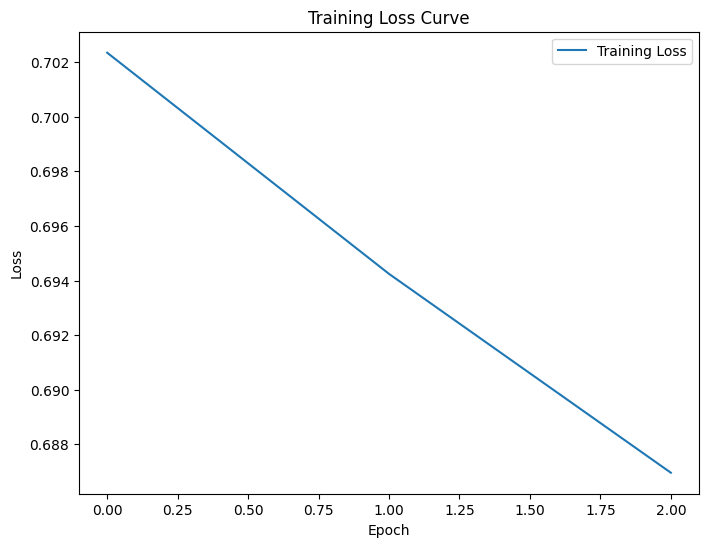

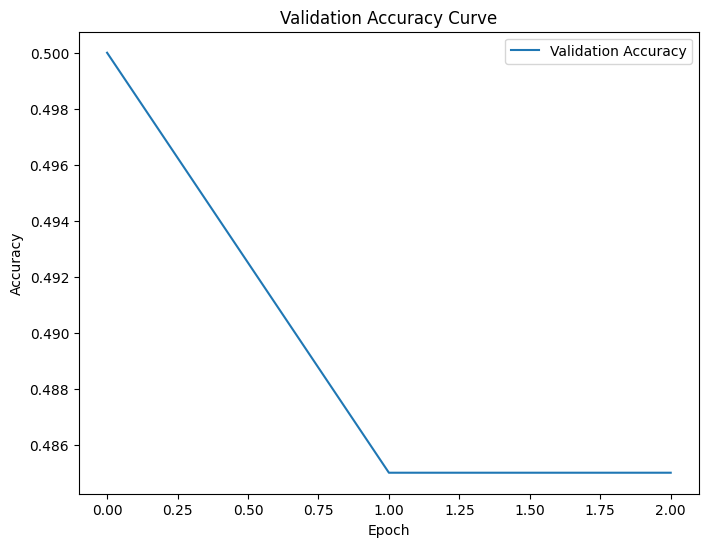

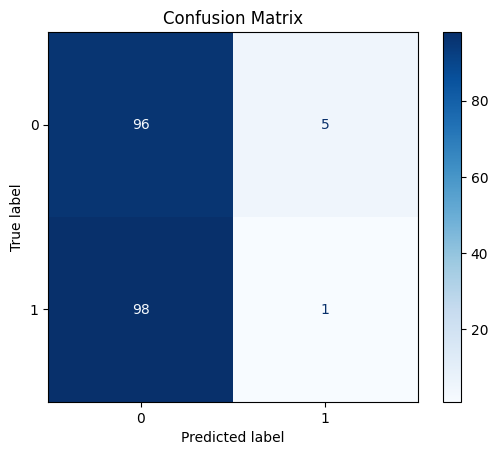

In [ ]:
# Install necessary libraries
!pip install transformers datasets matplotlib scikit-learn

# Import libraries
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import get_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# Load dataset from uploaded file
from google.colab import files
uploaded = files.upload()  # Manually upload your CSV file
filename = list(uploaded.keys())[0]

# Read the dataset
df = pd.read_csv('/content/df_merge.csv')

# Display the first few rows to understand the structure
print("Dataset preview:")
print(df.head())

# Ensure proper columns are present and add labels if needed
if 'text' not in df.columns:
    raise ValueError("Dataset must contain a 'text' column.")

if 'label' not in df.columns:
    import numpy as np
    np.random.seed(42)  # For reproducibility
    df['label'] = np.random.randint(0, 2, size=len(df))  # Binary labels: 0 or 1

# Optional: Reduce dataset size for quick testing
df = df.sample(1000, random_state=42)  # Use 1000 samples for training

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
        }

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer, max_len=64)
val_dataset = FakeNewsDataset(val_texts, val_labels, tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduced batch size
val_loader = DataLoader(val_dataset, batch_size=8)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Mixed precision training setup
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Training loop
epochs = 3
progress_bar = tqdm(range(num_training_steps))
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast():
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']
            )
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_predictions = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_predictions.extend(predictions.cpu().numpy())
            val_labels_list.extend(batch['label'].cpu().numpy())
            correct += (predictions == batch['label']).sum().item()
            total += batch['label'].size(0)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    precision, recall, f1, _ = precision_recall_fscore_support(val_labels_list, val_predictions, average='binary')
    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot Validation Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels_list, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
